In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
# Increases the size of sns plots
sns.set(rc={'figure.figsize':(12,10)})
# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.set_option('display.max_columns', None)
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer

In [66]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('train shape : {}'.format(train.shape))
print('test shape : {}'.format(test.shape))

train shape : (1460, 81)
test shape : (1459, 80)


In [5]:
x = pd.concat([train.drop('SalePrice',axis=1), test], axis=0)
y = train['SalePrice']

print('train&test shape: {}'.format(x.shape))

train&test shape: (2919, 80)


In [6]:
# isolate numerical and catgorical features
# differentiate continuous/dis-continuous features


num_var = x.select_dtypes(exclude=['object']).drop(['Id','MSSubClass'], axis=1).copy()
print(num_var.columns)


disc_num_var = ['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']
cont_num_var = []
for i in num_var.columns:
    if i not in disc_num_var:
        cont_num_var.append(i)

print('*'*50)
        
cat_train = x.select_dtypes(include=['object']).copy()
cat_train['MSSubClass'] = x['MSSubClass']   #MSSubClass is nominal
print(cat_train.columns)

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')
**************************************************
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
 

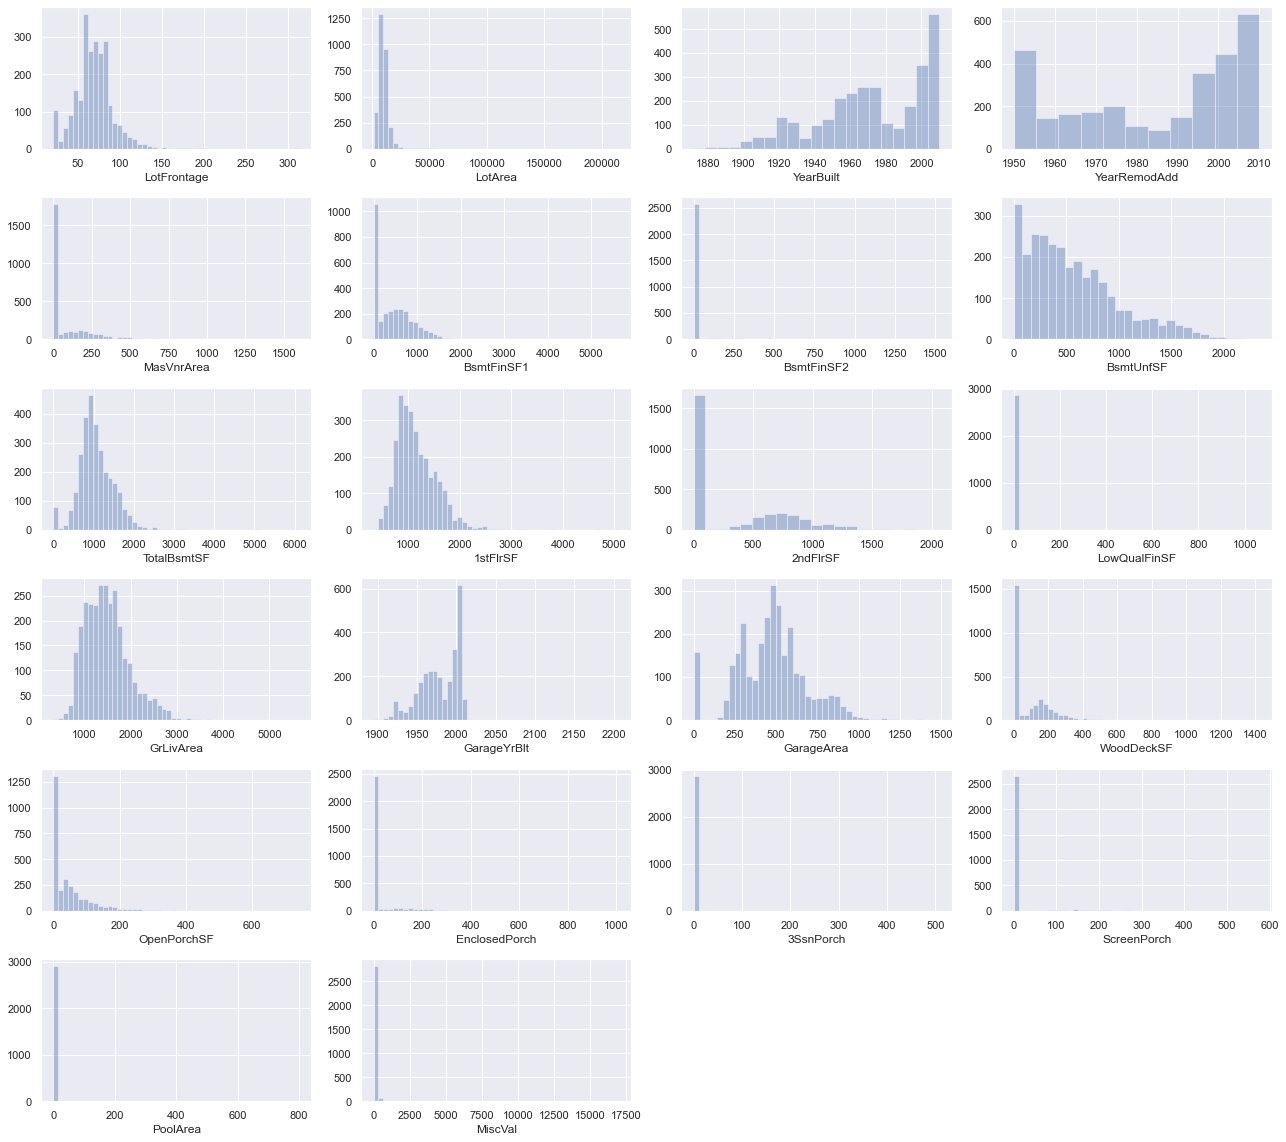

In [7]:
fig = plt.figure(figsize=(18,16))

for index,col in enumerate(cont_num_var):
    plt.subplot(6,4,index+1)
    sns.distplot(num_var.loc[:,col].dropna(), kde=False)
    
fig.tight_layout(pad=1.0)


# based on univariate analysis, there are some feature have most '1' values, they do not add much value to our model result
# BsmtFinSF2 ; LowQualFinSF; EnclosedPorch; 3SsnPorch; ScreenPorch; PoolArea ; MiscVal

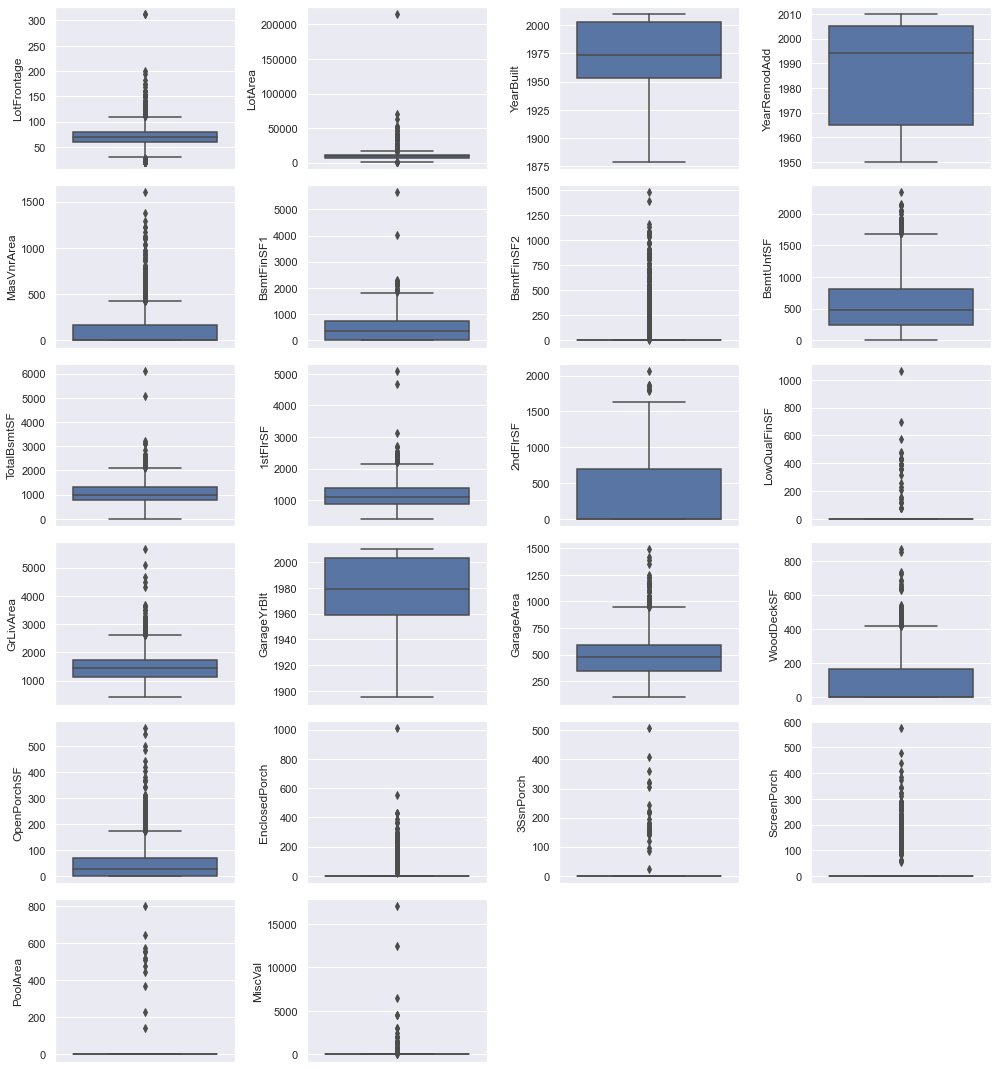

In [8]:
fig = plt.figure(figsize=(14,15))
for index,col in enumerate(cont_num_var):
    plt.subplot(6,4,index+1)
    sns.boxplot(y=col, data=num_var.dropna())
fig.tight_layout(pad=1.0)

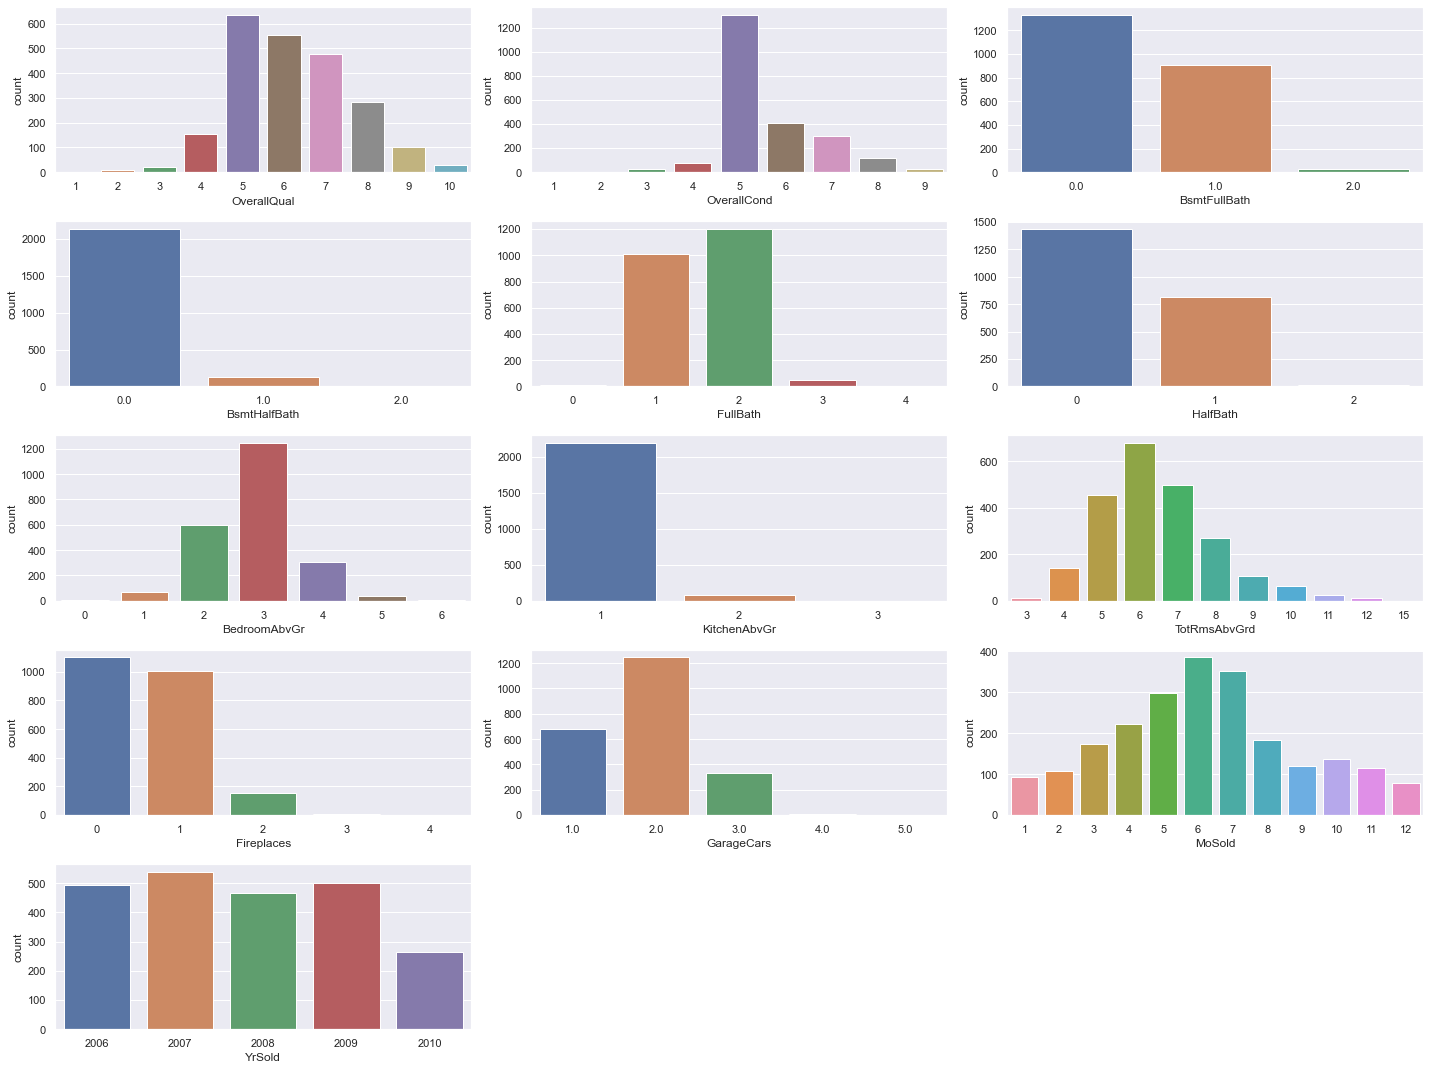

In [9]:
fig = plt.figure(figsize=(20,15))
for index,col in enumerate(disc_num_var):
    plt.subplot(5,3,index+1)
    sns.countplot(x=col, data=num_var.dropna())
fig.tight_layout(pad=1.0)

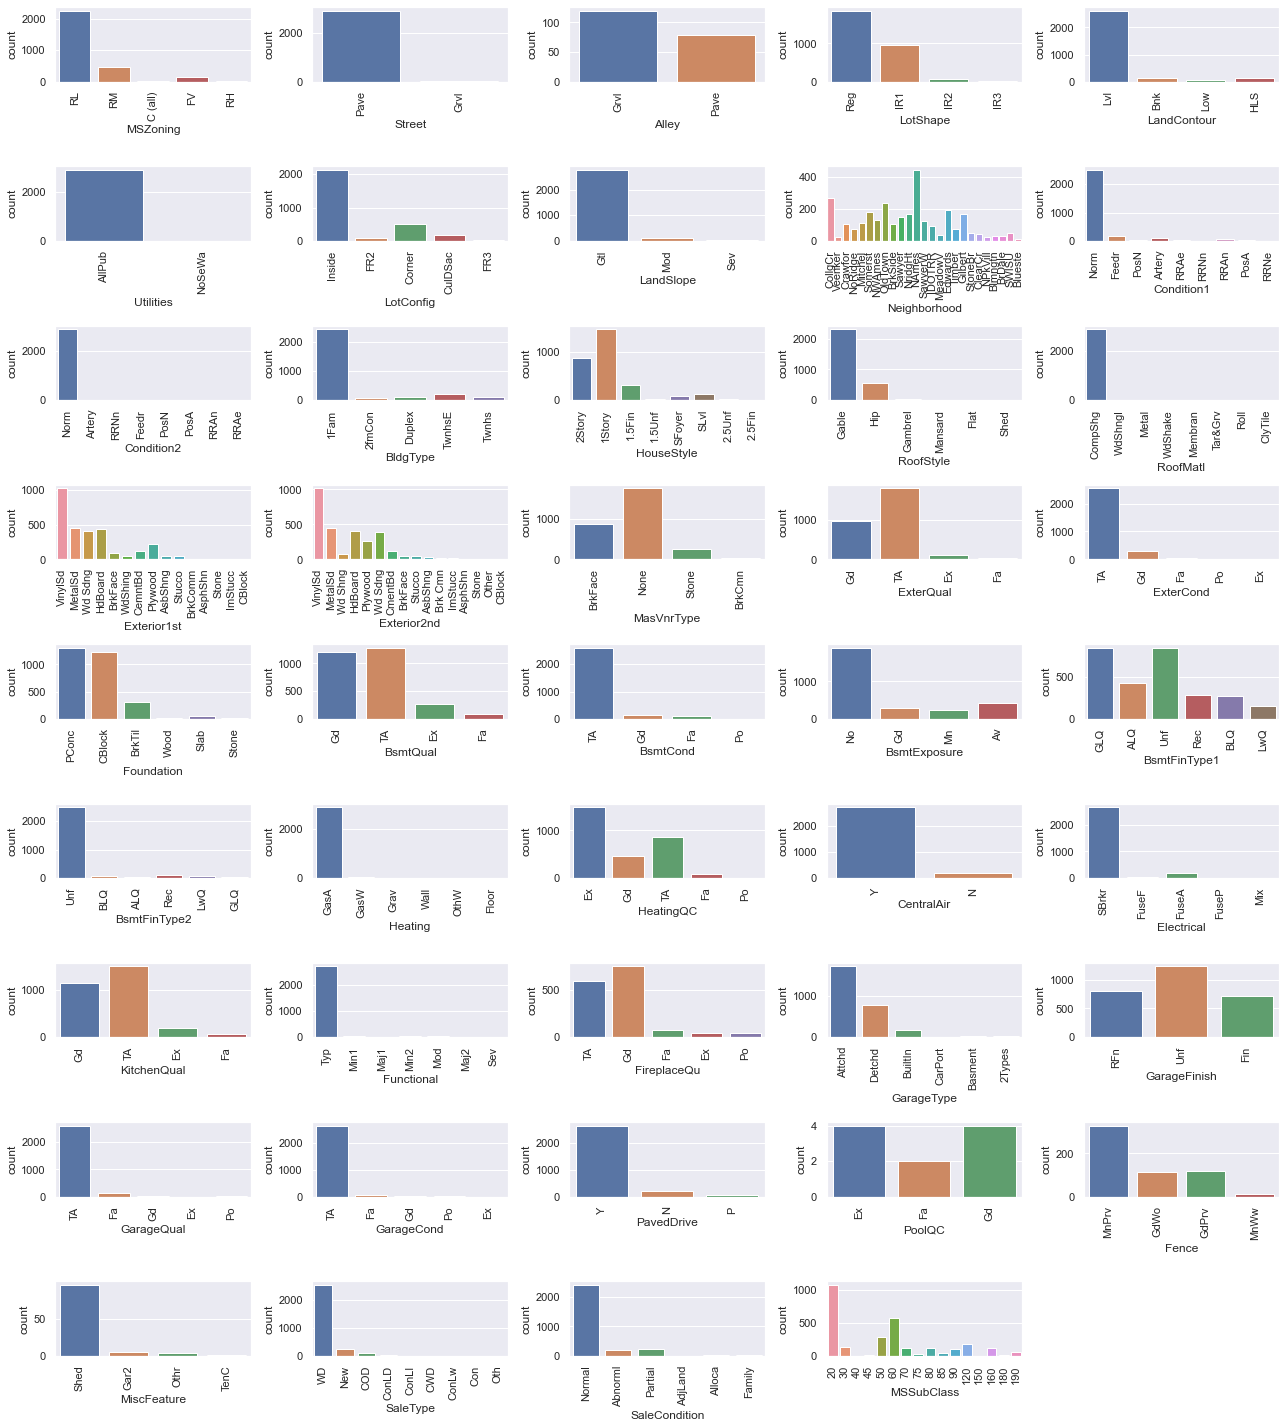

In [10]:
fig = plt.figure(figsize=(18,20))
for index in range(len(cat_train.columns)):
    plt.subplot(9,5,index+1)
    sns.countplot(x=cat_train.iloc[:,index], data=cat_train.dropna())
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

<AxesSubplot:>

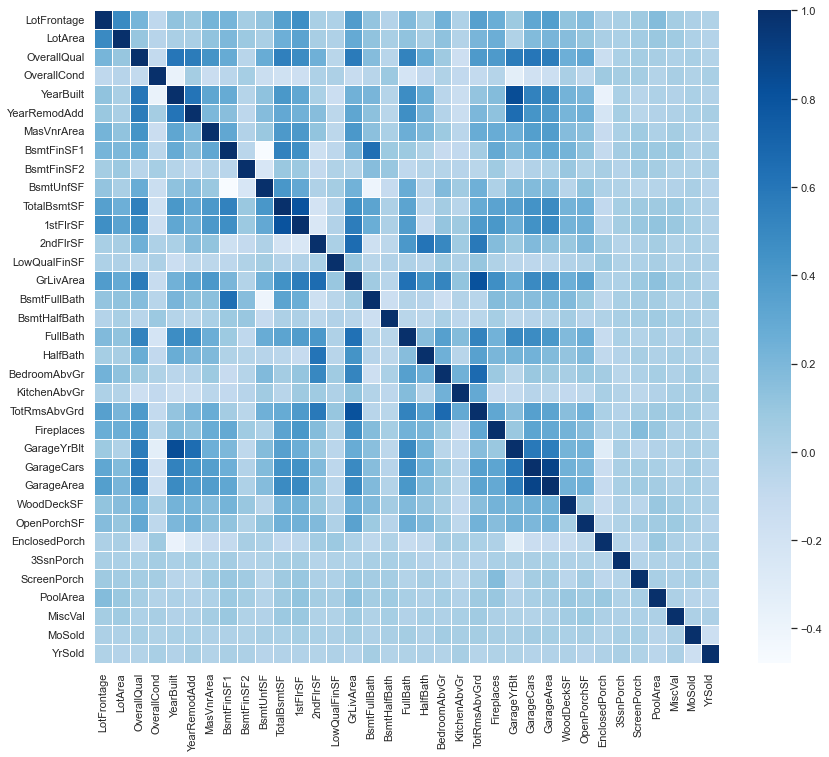

In [11]:
plt.figure(figsize=(14,12))
correlation = num_var.corr()
sns.heatmap(correlation,   linewidth=0.5, cmap='Blues')

Highly Correlated variables:

GarageYrBlt and YearBuilt
TotRmsAbvGrd and GrLivArea
1stFlrSF and TotalBsmtSF
GarageArea and GarageCars


From the correlation matrix we have identified the above variables which are highly correlated with each other. This finding will guide us in our preprocessing steps later on as we aim to remove highly correlated features to avoid performance loss in our model

In [12]:
numeric_train = train.select_dtypes(exclude=['object'])
correlation = numeric_train.corr()
correlation[['SalePrice']].sort_values(['SalePrice'], ascending=False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


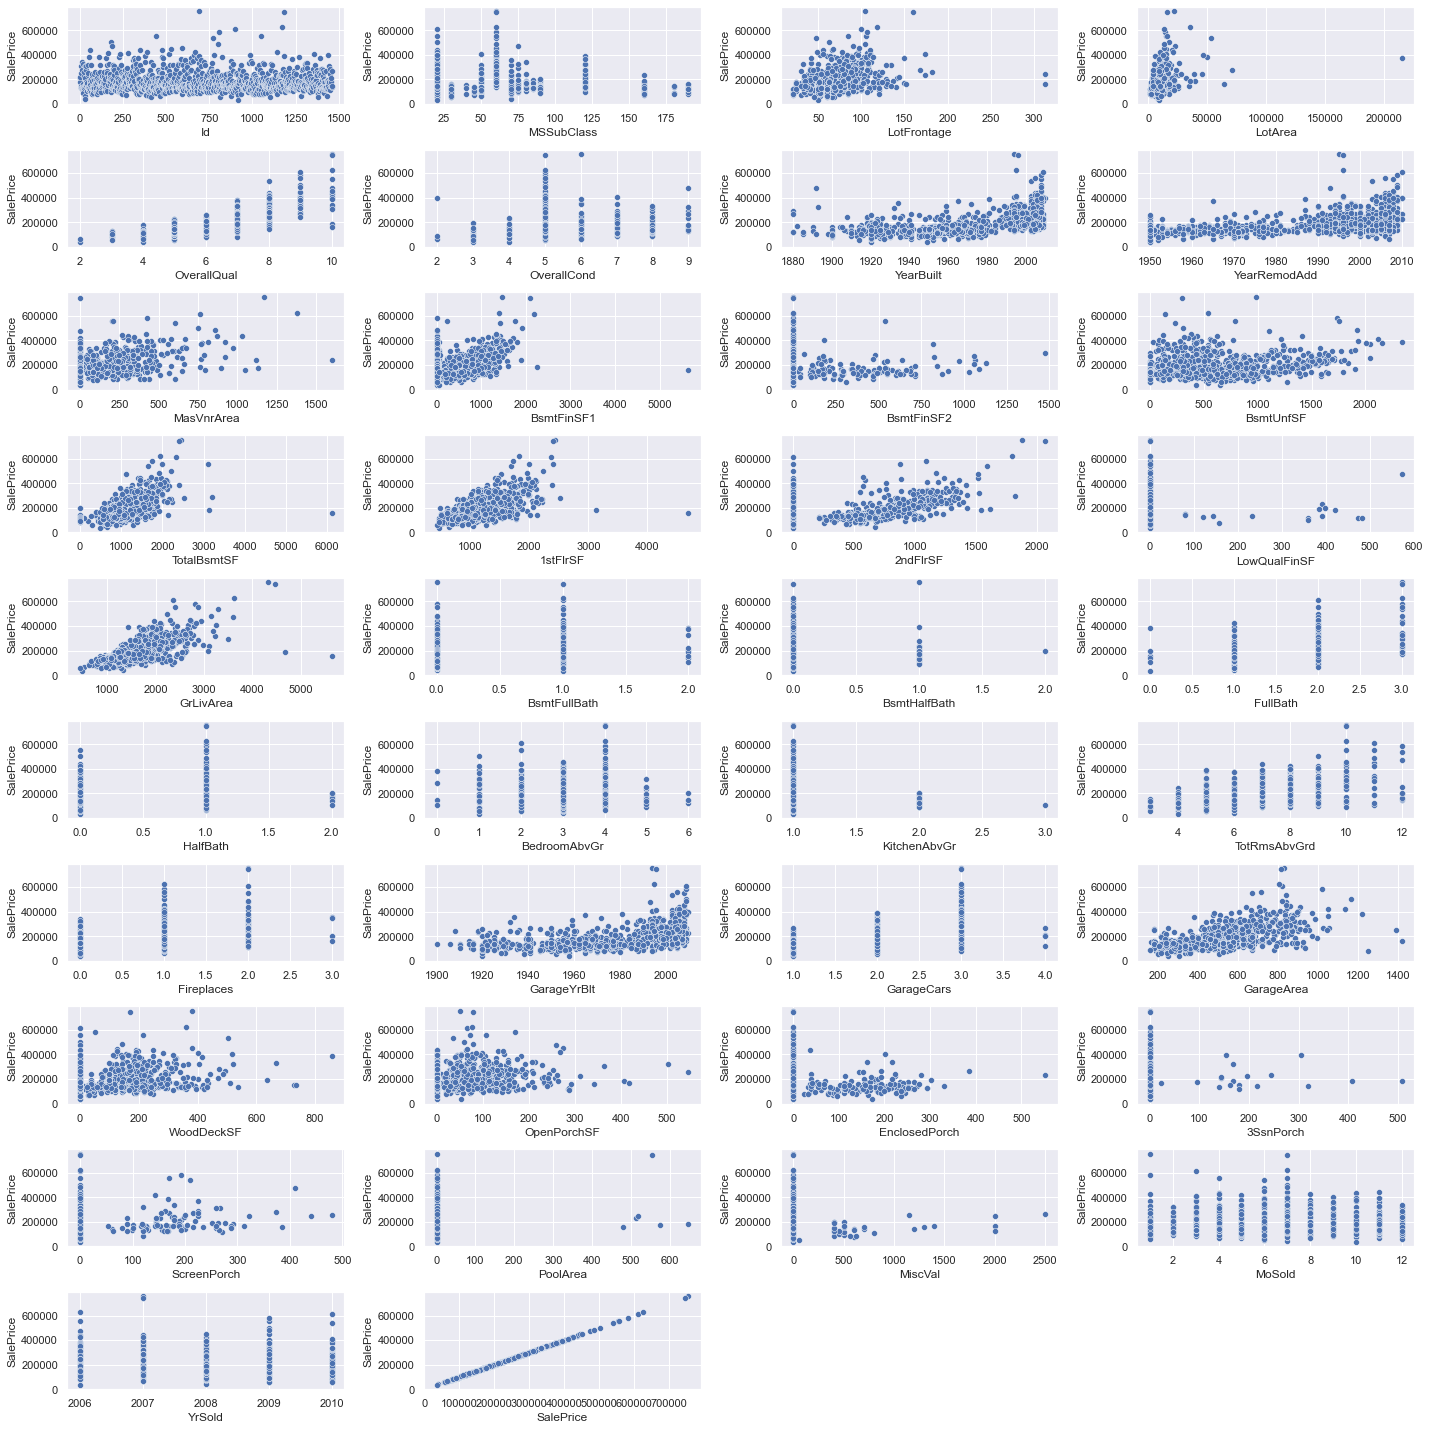

In [13]:
fig = plt.figure(figsize=(20,20))
for index in range(len(numeric_train.columns)):
    plt.subplot(10,4,index+1)
    sns.scatterplot(x=numeric_train.iloc[:,index], y='SalePrice', data=numeric_train.dropna())
fig.tight_layout(pad=1.0)

In [14]:
# Features with multicollinearity
x.drop(['GarageYrBlt','TotRmsAbvGrd','1stFlrSF','GarageCars'], axis=1, inplace=True)

<AxesSubplot:title={'center':'Number of missing rows'}, xlabel='features', ylabel='sum'>

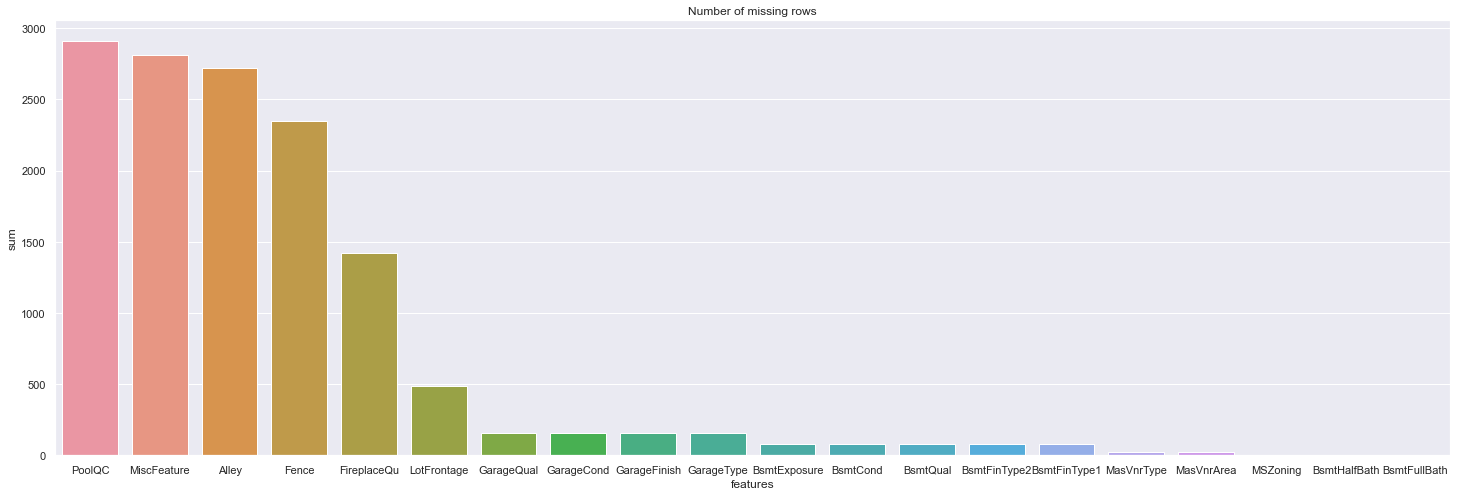

In [15]:
plt.figure(figsize=(25,8))
plt.title('Number of missing rows')
missing_count = pd.DataFrame(x.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(20).reset_index()
missing_count.columns = ['features','sum']
sns.barplot(x='features',y='sum', data = missing_count)

In [16]:
# Features with alot of missing values

x.drop(['PoolQC','MiscFeature','Alley'], axis=1, inplace=True)

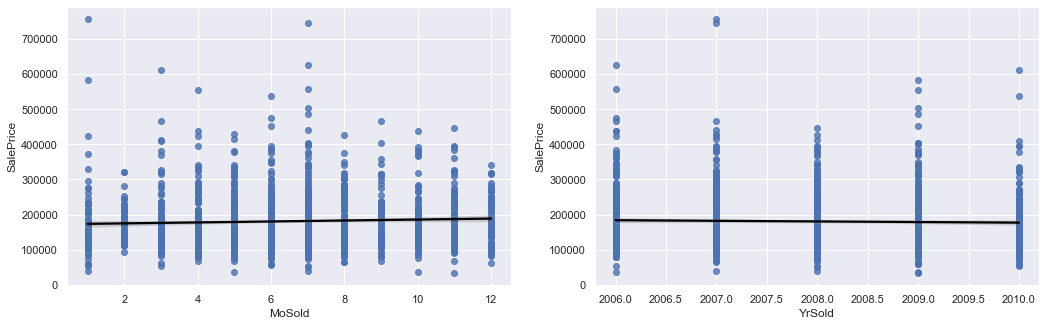

In [17]:
fig,axes = plt.subplots(1,2, figsize=(15,5))
sns.regplot(x=numeric_train['MoSold'], y='SalePrice', data=numeric_train, ax = axes[0], line_kws={'color':'black'})
sns.regplot(x=numeric_train['YrSold'], y='SalePrice', data=numeric_train, ax = axes[1],line_kws={'color':'black'})
fig.tight_layout(pad=2.0)

In [18]:
# Useless features in predicting SalePrice

correlation[['SalePrice']].sort_values(['SalePrice'], ascending=False).tail(10)
x.drop(['MoSold','YrSold'], axis=1, inplace=True)

In [19]:
# Removing features that have mostly just 1 value

cat_col = x.select_dtypes(include=['object']).columns
overfit_cat = []
for i in cat_col:
    counts = x[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(x) * 100 > 96:
        overfit_cat.append(i)

overfit_cat = list(overfit_cat)
x = x.drop(overfit_cat, axis=1)

num_col = x.select_dtypes(exclude=['object']).drop(['MSSubClass'], axis=1).columns
overfit_num = []
for i in num_col:
    counts = x[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(x) * 100 > 96:
        overfit_num.append(i)

overfit_num = list(overfit_num)
x = x.drop(overfit_num, axis=1)

print("Categorical Features with >96% of the same value: ",overfit_cat)
print("Numerical Features with >96% of the same value: ",overfit_num)

Categorical Features with >96% of the same value:  ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']
Numerical Features with >96% of the same value:  ['LowQualFinSF', '3SsnPorch', 'PoolArea', 'MiscVal']


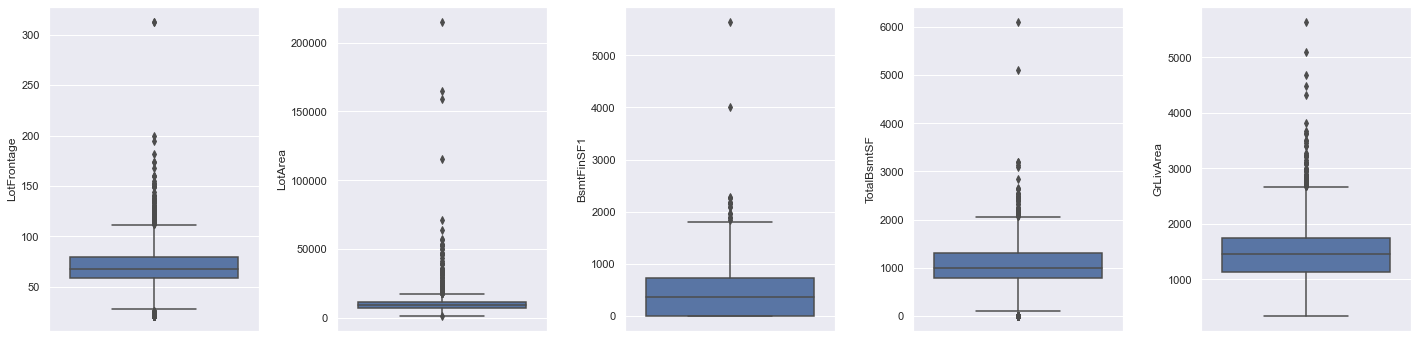

In [20]:
# remove outlier

out_col = ['LotFrontage','LotArea','BsmtFinSF1','TotalBsmtSF','GrLivArea']
fig = plt.figure(figsize=(20,5))
for index,col in enumerate(out_col):
    plt.subplot(1,5,index+1)
    sns.boxplot(y=col, data=x)
fig.tight_layout(pad=1.5)

In [21]:
train.shape

(1460, 81)

In [22]:
train = train.drop(train[train['LotFrontage'] > 200].index)
train = train.drop(train[train['LotArea'] > 100000].index)
train = train.drop(train[train['BsmtFinSF1'] > 4000].index)
train = train.drop(train[train['TotalBsmtSF'] > 5000].index)
train = train.drop(train[train['GrLivArea'] > 4000].index)

In [23]:
train.shape

(1451, 81)

In [24]:
x.shape

(2919, 62)

In [25]:
train.shape

(1451, 81)

In [26]:
# filling missing values

pd.DataFrame(x.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(15)

,sum
Fence,2348
FireplaceQu,1420
LotFrontage,486
GarageCond,159
GarageQual,159
GarageFinish,159
GarageType,157
BsmtCond,82
BsmtExposure,82
BsmtQual,81


In [27]:
# ordinal features

cat = ['GarageType','GarageFinish','BsmtFinType2','BsmtExposure','BsmtFinType1', 
       'GarageCond','GarageQual','BsmtCond','BsmtQual','FireplaceQu','Fence',"KitchenQual",
       "HeatingQC",'ExterQual','ExterCond']

x[cat] = x[cat].fillna("NA")

In [28]:
# categorical

cols = ["MasVnrType", "MSZoning", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "Functional"]
x[cols] = x.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.mode()[0]))

Mean of LotFrontage:  69.30579531442663
Mean of GarageArea:  472.8745716244003


<AxesSubplot:xlabel='Neighborhood', ylabel='GarageArea_mean'>

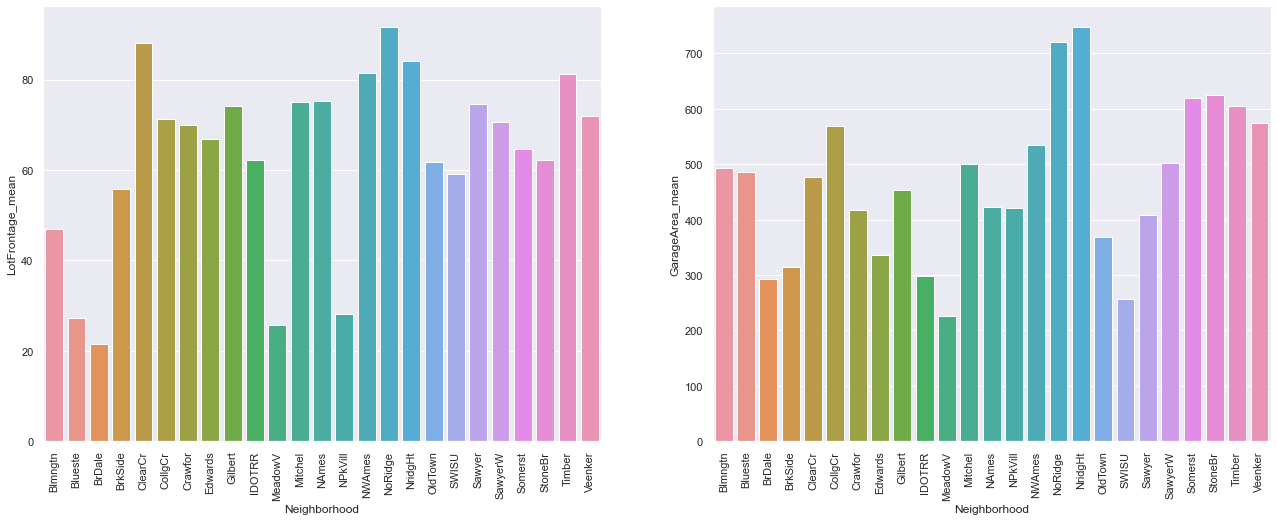

In [29]:
# numerical

print("Mean of LotFrontage: ", x['LotFrontage'].mean())
print("Mean of GarageArea: ", x['GarageArea'].mean())

neigh_lot = x.groupby('Neighborhood')['LotFrontage'].mean().reset_index(name='LotFrontage_mean')
neigh_garage = x.groupby('Neighborhood')['GarageArea'].mean().reset_index(name='GarageArea_mean')

fig, axes = plt.subplots(1,2,figsize=(22,8))
axes[0].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='LotFrontage_mean', data=neigh_lot, ax=axes[0])
axes[1].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='GarageArea_mean', data=neigh_garage, ax=axes[1])

In [30]:
#for correlated relationship
x['LotFrontage'] = x.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
x['GarageArea'] = x.groupby('Neighborhood')['GarageArea'].transform(lambda x: x.fillna(x.mean()))
x['MSZoning'] = x.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

#numerical
cont = ["BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea"]
x[cont] = x[cont] = x[cont].fillna(x[cont].mean())


In [31]:
# MSSubClass is an integer column based on some mapped values in string notation, 
# we change its data type to string value instead

x['MSSubClass'] = x['MSSubClass'].apply(str)

In [32]:
# Mapping Ordinal Features¶

ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}
fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}


ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond', 'FireplaceQu']
for col in ord_col:
    x[col] = x[col].map(ordinal_map)
    
fin_col = ['BsmtFinType1','BsmtFinType2']
for col in fin_col:
    x[col] = x[col].map(fintype_map)

x['BsmtExposure'] = x['BsmtExposure'].map(expose_map)
x['Fence'] = x['Fence'].map(fence_map)


In [33]:
x['TotalLot'] = x['LotFrontage'] + x['LotArea']
x['TotalBsmtFin'] = x['BsmtFinSF1'] +x['BsmtFinSF2']
x['TotalSF'] =x['TotalBsmtSF'] + x['2ndFlrSF']
x['TotalBath'] = x['FullBath'] + x['HalfBath']
x['TotalPorch'] = x['OpenPorchSF'] + x['EnclosedPorch'] + x['ScreenPorch']

In [34]:
colum = ['MasVnrArea','TotalBsmtFin','TotalBsmtSF','2ndFlrSF','WoodDeckSF','TotalPorch']

for col in colum:
    col_name = col+'_bin'
    x[col_name] = x[col].apply(lambda x: 1 if x > 0 else 0)

In [35]:
x.shape

(2919, 73)

In [36]:
x = pd.get_dummies(x)
x.shape

(2919, 224)

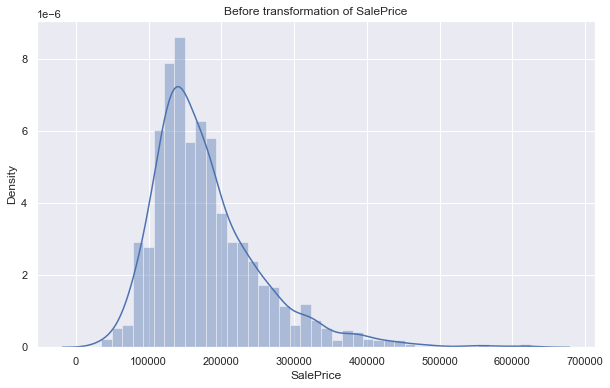

In [37]:
plt.figure(figsize=(10,6))
plt.title("Before transformation of SalePrice")
dist = sns.distplot(train['SalePrice'],norm_hist=False)

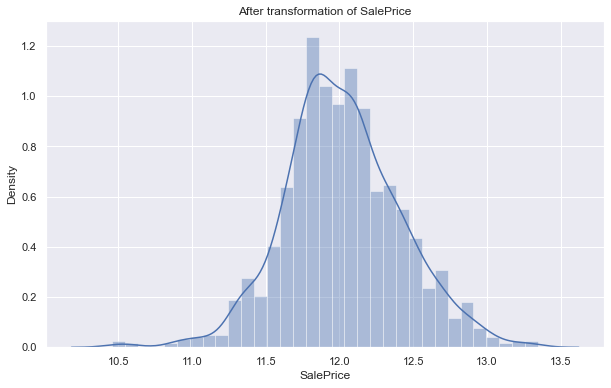

In [38]:
plt.figure(figsize=(10,6))
plt.title("After transformation of SalePrice")
dist = sns.distplot(np.log(train['SalePrice']),norm_hist=False)

In [67]:
# log-transformation

y = np.log(train['SalePrice'])

# Model

In [76]:
# many confusion in this part 

train_x = x.iloc[0:1460,1:]
train_y = y
test = x.iloc[1460:2919, 1:]

In [81]:
from sklearn.preprocessing import RobustScaler

cols = train_x.select_dtypes(np.number).columns
transformer = RobustScaler().fit(train_x[cols])
train_x[cols] = transformer.transform(train_x[cols])

test[cols] = transformer.transform(test[cols])

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=2020)

In [90]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn import ensemble
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor

In [91]:
'''
Find out more on the XGBRegressor implementation and parameters at 
https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster
'''

# xgb = XGBRegressor(booster='gbtree', learning_rate=0.3, n_estimators=3460,
#                     max_depth=6, min_child_weight=1, subsample=1,
#                     gamma=0, reg_alpha = 0.001, colsample_bytree=0.7,
#                     objective='reg:squarederror', reg_lambda = 0.001,
#                     scale_pos_weight=1, seed=2020)

xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror')

In [92]:
from sklearn.model_selection import RandomizedSearchCV

param_lst = {
    'learning_rate' : [0.01, 0.1, 0.15, 0.3, 0.5],
    'n_estimators' : [100, 500, 1000, 2000, 3000],
    'max_depth' : [3, 6, 9],
    'min_child_weight' : [1, 5, 10, 20],
    'reg_alpha' : [0.001, 0.01, 0.1],
    'reg_lambda' : [0.001, 0.01, 0.1]
}

xgb_reg = RandomizedSearchCV(estimator = xgb, param_distributions = param_lst,
                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
                              cv = 5)
       
xgb_search = xgb_reg.fit(X_train, y_train)

# XGB with tune hyperparameters
best_param = xgb_search.best_params_
xgb = XGBRegressor(**best_param)

In [120]:
"""
Learn more avout LightBGM parameters at 
https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
"""

lgbm = LGBMRegressor(boosting_type='gbdt',objective='regression', max_depth=-1,
                    lambda_l1=0.0001, lambda_l2=0, learning_rate=0.1,
                    n_estimators=100, max_bin=200, min_child_samples=20, 
                    bagging_fraction=0.75, bagging_freq=5,
                    bagging_seed=7, feature_fraction=0.8,
                    feature_fraction_seed=7, verbose=-1)

In [121]:
param_lst = {
    'max_depth' : [2, 5, 8, 10],
    'learning_rate' : [0.001, 0.01, 0.1, 0.2],
    'n_estimators' : [100, 300, 500, 1000, 1500],
    'lambda_l1' : [0.0001, 0.001, 0.01],
    'lambda_l2' : [0, 0.0001, 0.001, 0.01],
    'feature_fraction' : [0.4, 0.6, 0.8],
    'min_child_samples' : [5, 10, 20, 25]
}

lightgbm = RandomizedSearchCV(estimator = lgbm, param_distributions = param_lst,
                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
                              cv = 5)
       
lightgbm_search = lightgbm.fit(X_train, y_train)

# LightBGM with tuned hyperparameters
best_param = lightgbm_search.best_params_
lgbm = LGBMRegressor(**best_param)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value:

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Cur

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current val

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current 

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Cur

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. 

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Curr

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current va

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: 

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value:

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Curren

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value:

[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current va

[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value:

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value:

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: 

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: baggi

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Curr

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Cu

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current val

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current v

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current 

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current va

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Curren

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value:

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current val

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current

In [122]:
cb = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')

In [123]:
param_lst = {
    'n_estimators' : [100, 300, 500, 1000, 1300, 1600],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1],
    'l2_leaf_reg' : [0.001, 0.01, 0.1],
    'random_strength' : [0.25, 0.5 ,1],
    'max_depth' : [3, 6, 9],
    'min_child_samples' : [2, 5, 10, 15, 20],
    'rsm' : [0.5, 0.7, 0.9],
    
}

catboost = RandomizedSearchCV(estimator = cb, param_distributions = param_lst,
                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
                              cv = 5)

catboost_search = catboost.fit(X_train, y_train)

# CatBoost with tuned hyperparams
best_param = catboost_search.best_params_
cb = CatBoostRegressor(logging_level='Silent', **best_param)

In [94]:
def mean_cross_val(model, X, y):
    score = cross_val_score(model, X, y, cv=5)
    mean = score.mean()
    return mean

In [124]:
xgb.fit(X_train, y_train)   
preds = xgb.predict(X_val) 
preds_test_xgb = xgb.predict(test)
mae_xgb = mean_absolute_error(y_val, preds)
rmse_xgb = np.sqrt(mean_squared_error(y_val, preds))
score_xgb = xgb.score(X_val, y_val)
cv_xgb = mean_cross_val(xgb, X_train, y_train)


lgbm.fit(X_train, y_train)   
preds = lgbm.predict(X_val) 
preds_test_lgbm = lgbm.predict(test)
mae_lgbm = mean_absolute_error(y_val, preds)
rmse_lgbm = np.sqrt(mean_squared_error(y_val, preds))
score_lgbm = lgbm.score(X_val, y_val)
cv_lgbm = mean_cross_val(lgbm, X_train, y_train)

cb.fit(X_train, y_train)   
preds = cb.predict(X_val) 
preds_test_cb = cb.predict(test)
mae_cb = mean_absolute_error(y_val, preds)
rmse_cb = np.sqrt(mean_squared_error(y_val, preds))
score_cb = cb.score(X_val, y_val)
cv_cb = mean_cross_val(cb, X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current 

In [125]:
model_performances = pd.DataFrame({
    "Model" : ["XGBoost", "LGBM", "CatBoost"],
    "CV(5)" : [str(cv_xgb)[0:5], str(cv_lgbm)[0:5], str(cv_cb)[0:5]],
    "MAE" : [str(mae_xgb)[0:5], str(mae_lgbm)[0:5], str(mae_cb)[0:5]],
    "RMSE" : [str(rmse_xgb)[0:5], str(rmse_lgbm)[0:5], str(rmse_cb)[0:5]],
    "Score" : [str(score_xgb)[0:5], str(score_lgbm)[0:5], str(score_cb)[0:5]]
})

print("Sorted by Score:")
print(model_performances.sort_values(by="Score", ascending=False))

Sorted by Score:
      Model  CV(5)    MAE   RMSE  Score
2  CatBoost  0.892  0.075  0.100  0.942
1      LGBM  0.880  0.075  0.102  0.939
0   XGBoost  0.878  0.076  0.104  0.937


### Blending

In [144]:
def blend_models_predict(X, b, c, d):
        return ((b* xgb.predict(X)) + (c * lgbm.predict(X)) + (d * cb.predict(X)))

In [160]:
subm = np.exp(blend_models_predict(test, 0, 0.4, 0.6))

In [129]:
submission_xgb = np.exp(xgb.predict(test))
submission_lgb = np.exp(lgbm.predict(test))
submission_cb = np.exp(cb.predict(test))

In [115]:
submission = pd.DataFrame({'Id': test_id.Id,
                           'SalePrice': submission})

ValueError: Data must be 1-dimensional

In [140]:
submission_result_lgb = submission.copy()
submission_result_lgb['SalePrice'] = submission_lgb

submission_result_cb = submission.copy()
submission_result_cb['SalePrice'] = submission_cb

In [139]:
submission_result_lgb.head()

,Id,SalePrice
0,1461,127402.853554
1,1462,160923.098461
2,1463,185869.669216
3,1464,190962.115904
4,1465,191028.982696


In [141]:
submission_result_cb.head()

,Id,SalePrice
0,1461,133069.051515
1,1462,162198.979083
2,1463,185804.983555
3,1464,197175.545819
4,1465,181088.271645


In [161]:
submission_result_blend = submission.copy()
submission_result_blend['SalePrice'] = subm

In [158]:
submission_result_blend.head()

,Id,SalePrice
0,1461,130992.725168
1,1462,162147.572804
2,1463,186162.288245
3,1464,194628.067351
4,1465,183724.036675


In [119]:
submission.to_csv('submission3.csv', index=False)

In [142]:
submission_result_cb.to_csv('submission_result_cb.csv', index=False)

In [143]:
submission_result_lgb.to_csv('submission_result_lgb.csv', index=False)

In [162]:
submission_result_blend.to_csv('submission_result_blend4.csv', index=False)

In [55]:
# working file built and storage

import os
cwd = os.getcwd()
cwd

'C:\\Users\\jingw\\OneDrive\\Desktop\\DS Practice - python code\\House Price'

In [57]:
nwd='C:\\Users\\jingw\\OneDrive\\Desktop\\DS Practice - python code\\House Price\\House price dataset'
path = nwd +"\\data_v1.csv"

data_v1.to_csv(path, encoding='utf-8', index=False)

In [58]:
df1 = pd.read_csv(path)


In [59]:
df1.head()
df1.shape

(1460, 303)